**Video Style Transfer with Temporal Consistency and Segmentation Guidance**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
# Set up paths
data_dir = "/kaggle/input/davis2017content/DAVIS-2017-trainval-480p_main/DAVIS-2017-trainval-480p_main/DAVIS"
images_dir = os.path.join(data_dir, "JPEGImages")
annotations_dir = os.path.join(data_dir, "Annotations")
image_sets_dir = "/kaggle/input/davis2017content/DAVIS-2017-trainval-480p_main/DAVIS-2017-trainval-480p_main/DAVIS/ImageSets"
train_file = os.path.join(image_sets_dir, "train.txt")
val_file = os.path.join(image_sets_dir, "val.txt")

In [4]:
with open(train_file, "r") as f:
    train_classes = f.read().splitlines()

with open(val_file, "r") as f:
    val_classes = f.read().splitlines()

In [5]:
IMG_SIZE = 256
TRAIN_BATCH_SIZE = 4

In [6]:
def get_all_frame_mask_paths(classes):
    frame_paths = []
    mask_paths = []
    for class_name in classes:
        # Clean class_name to extract base name (e.g., 'bear' from any malformed path)
        class_name = os.path.basename(class_name.strip())
        class_image_dir = os.path.join(images_dir, "480p", class_name)
        class_annotation_dir = os.path.join(annotations_dir, "480p", class_name)
        frames = sorted([os.path.join(class_image_dir, f) for f in os.listdir(class_image_dir) if f.endswith('.jpg')])
        masks = sorted([os.path.join(class_annotation_dir, f) for f in os.listdir(class_annotation_dir) if f.endswith('.png')])
        frame_paths.extend(frames)
        mask_paths.extend(masks)
    return frame_paths, mask_paths

In [7]:
train_frame_paths, train_mask_paths = get_all_frame_mask_paths(train_classes)
val_frame_paths, val_mask_paths = get_all_frame_mask_paths(val_classes)

print(f"Number of training samples: {len(train_frame_paths)}")
print(f"Number of validation samples: {len(val_frame_paths)}")

Number of training samples: 4209
Number of validation samples: 1999


In [8]:
print("Train classes:", train_classes)

Train classes: ['DAVIS/JPEGImages/480p/bear DAVIS/JPEGImages/480p/bear', 'DAVIS/JPEGImages/480p/bmx-bumps DAVIS/JPEGImages/480p/bmx-bumps', 'DAVIS/JPEGImages/480p/boat DAVIS/JPEGImages/480p/boat', 'DAVIS/JPEGImages/480p/boxing-fisheye DAVIS/JPEGImages/480p/boxing-fisheye', 'DAVIS/JPEGImages/480p/breakdance-flare DAVIS/JPEGImages/480p/breakdance-flare', 'DAVIS/JPEGImages/480p/bus DAVIS/JPEGImages/480p/bus', 'DAVIS/JPEGImages/480p/car-turn DAVIS/JPEGImages/480p/car-turn', 'DAVIS/JPEGImages/480p/cat-girl DAVIS/JPEGImages/480p/cat-girl', 'DAVIS/JPEGImages/480p/classic-car DAVIS/JPEGImages/480p/classic-car', 'DAVIS/JPEGImages/480p/color-run DAVIS/JPEGImages/480p/color-run', 'DAVIS/JPEGImages/480p/crossing DAVIS/JPEGImages/480p/crossing', 'DAVIS/JPEGImages/480p/dance-jump DAVIS/JPEGImages/480p/dance-jump', 'DAVIS/JPEGImages/480p/dancing DAVIS/JPEGImages/480p/dancing', 'DAVIS/JPEGImages/480p/disc-jockey DAVIS/JPEGImages/480p/disc-jockey', 'DAVIS/JPEGImages/480p/dog-agility DAVIS/JPEGImages/48

In [9]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image

def load_and_preprocess_mask(path):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method='nearest')
    mask = tf.cast(mask > 0, tf.float32)  # Binary mask
    return mask

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_frame_paths, train_mask_paths))
train_dataset = train_dataset.map(lambda x, y: (load_and_preprocess_image(x), load_and_preprocess_mask(y)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(TRAIN_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_frame_paths, val_mask_paths))
val_dataset = val_dataset.map(lambda x, y: (load_and_preprocess_image(x), load_and_preprocess_mask(y)), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(TRAIN_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
def unet_model(output_channels=1):
    inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    
    # Downsampling
    x = inputs
    skips = []
    for filters in [64, 128, 256, 512]:
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        skips.append(x)
        x = layers.MaxPooling2D(2)(x)
    
    # Bottleneck
    x = layers.Conv2D(1024, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(1024, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Upsampling
    for filters in [512, 256, 128, 64]:
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
        skip = skips.pop()
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        
    # Output layer
    outputs = layers.Conv2D(output_channels, 1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersect
    iou = intersect / (union + 1e-7)
    return tf.reduce_mean(iou)

In [16]:
model = unet_model()

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)

def hybrid_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=hybrid_loss, metrics=['accuracy', iou_metric])

EPOCHS = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_iou_metric', mode='max', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8378 - iou_metric: 0.0333 - loss: 0.2832

E0000 00:00:1747341854.697729     712 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747341854.957101     712 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747341857.425590     712 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747341857.626529     712 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 397s 352ms/step - accuracy: 0.8379 - iou_metric: 0.0334 - loss: 0.2831 - val_accuracy: 0.8718 - val_iou_metric: 0.0306 - val_loss: 0.1982
Epoch 2/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 329s 310ms/step - accuracy: 0.8632 - iou_metric: 0.2886 - loss: 0.2174 - val_accuracy: 0.8697 - val_iou_metric: 0.0718 - val_loss: 0.2176
Epoch 3/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 329s 309ms/step - accuracy: 0.9024 - iou_metric: 0.4555 - loss: 0.1625 - val_accuracy: 0.8685 - val_iou_metric: 0.1529 - val_loss: 0.2146
Epoch 4/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 329s 309ms/step - accuracy: 0.9329 - iou_metric: 0.5665 - loss: 0.1149 - val_accuracy: 0.8711 - val_iou_metric: 0.2559 - val_loss: 0.2402
Epoch 5/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 329s 310ms/step - accuracy: 0.9563 - iou_metric: 0.6794 - loss: 0.0737 - val_accuracy: 0.8793 - val_iou_metric: 0.2825 - val_loss: 0.2307
Epoch 6/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 329s 309ms/step - accuracy: 0.9681 - iou_metric: 0.7433 - loss: 0.054

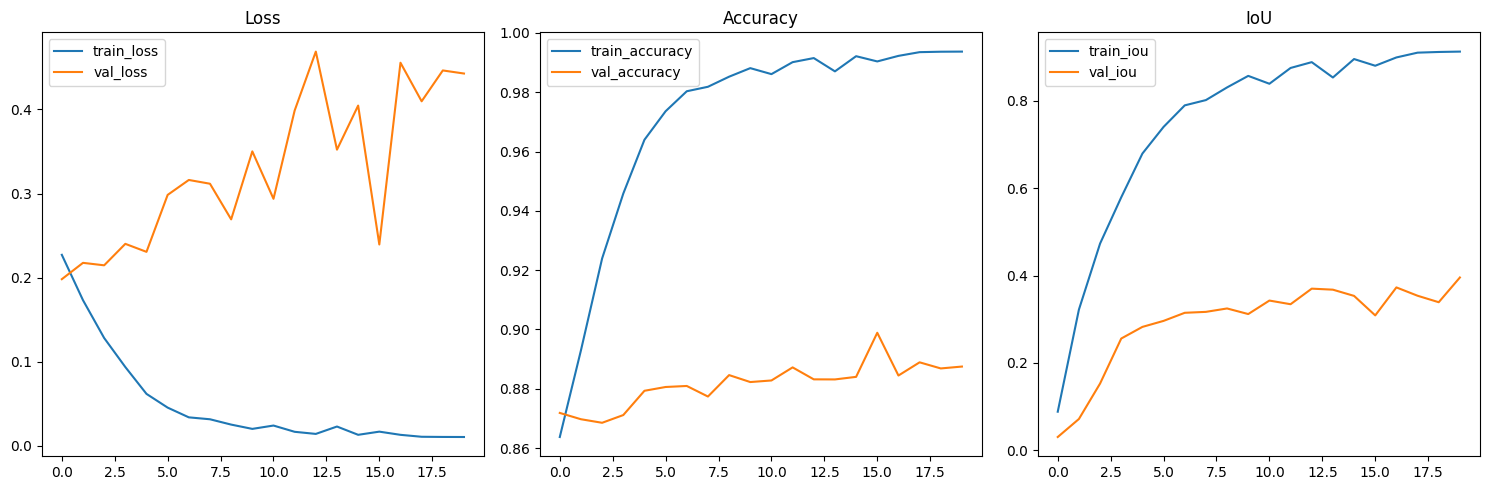

In [17]:
# Plotting
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['iou_metric'], label='train_iou')
plt.plot(history.history['val_iou_metric'], label='val_iou')
plt.title('IoU')
plt.legend()

plt.tight_layout()
plt.savefig('unet_training_metrics.png')
plt.show()

In [18]:
model.evaluate(val_dataset)

500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.8881 - iou_metric: 0.3660 - loss: 0.4033


[0.44276800751686096, 0.8874701857566833, 0.3955830931663513]

In [20]:

from tabulate import tabulate

# Assuming history is available from model.fit and eval_metrics from model.evaluate
# Example: history = model.fit(...)
# eval_metrics = model.evaluate(val_dataset)  # [0.4033, 0.8881, 0.3660]

# Extract metrics from history
table_data = []
for epoch in range(20):  # 20 epochs
    row = [
        epoch + 1,
        round(history.history['loss'][epoch], 4),
        round(history.history['val_loss'][epoch], 4),
        round(history.history['accuracy'][epoch], 4),
        round(history.history['val_accuracy'][epoch], 4),
        round(history.history['iou_metric'][epoch], 4),
        round(history.history['val_iou_metric'][epoch], 4)
    ]
    table_data.append(row)

# Append evaluation metrics
eval_metrics = [0.4033, 0.8881, 0.3660]  # From model.evaluate
table_data.append([
    "Eval",
    round(eval_metrics[0], 4),
    round(eval_metrics[0], 4),  # Same as eval loss for consistency
    round(eval_metrics[1], 4),
    round(eval_metrics[1], 4),  # Same as eval accuracy
    round(eval_metrics[2], 4),
    round(eval_metrics[2], 4)   # Same as eval IoU
])

# Define table headers
headers = [
    "Epoch",
    "Train Loss",
    "Val Loss",
    "Train Accuracy",
    "Val Accuracy",
    "Train IoU",
    "Val IoU"
]

# Print table using tabulate
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".4f"))

+---------+--------------+------------+------------------+----------------+-------------+-----------+
| Epoch   |   Train Loss |   Val Loss |   Train Accuracy |   Val Accuracy |   Train IoU |   Val IoU |
+=========+==============+============+==================+================+=============+===========+
| 1       |       0.2271 |     0.1982 |           0.8637 |         0.8718 |      0.0884 |    0.0306 |
+---------+--------------+------------+------------------+----------------+-------------+-----------+
| 2       |       0.1732 |     0.2176 |           0.8930 |         0.8697 |      0.3221 |    0.0718 |
+---------+--------------+------------+------------------+----------------+-------------+-----------+
| 3       |       0.1282 |     0.2146 |           0.9239 |         0.8685 |      0.4732 |    0.1529 |
+---------+--------------+------------+------------------+----------------+-------------+-----------+
| 4       |       0.0937 |     0.2402 |           0.9458 |         0.8711 |      0

In [22]:
# # Save the model
# model.save('unet_davis2017.h5')